In [1]:
import numpy as np, uproot as ur, awkward as ak, pandas as pd
import matplotlib.pyplot as plt
import os, sys
import pickle
import scipy.stats as st
from collections import defaultdict
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from scipy.stats import poisson, norm
from scipy.spatial import ConvexHull


import mplhep as hep
plt.figure()
hep.style.use("CMS")
plt.close()

def gaus(x, amp, mean, sigma):
    return amp * np.exp( -(x - mean)**2 / (2*sigma**2) ) 

def phi_reconstruct(x, y, z):
    return np.degrees(np.arctan2(y, x))
    
def theta_reconstruct(x, y, z):
    return np.degrees(np.arccos(abs(z)/np.sqrt(x**2+y**2+z**2)))

def vector_angle_reconstruct(x, y, z):
    data = np.concatenate((np.array(x)[:, np.newaxis], 
                           np.array(y)[:, np.newaxis], 
                           np.array(z)[:, np.newaxis]), 
                          axis=1)
    datamean = data.mean(axis=0)
    centered_data = data - datamean

    _, _, vv = np.linalg.svd(centered_data)
    direction_vector = vv[0]
    if direction_vector[2] > 0:
        direction_vector *= -1
        
    x_vec, y_vec, z_vec = direction_vector
    
    theta = theta_reconstruct(x_vec, y_vec, z_vec)
    phi = phi_reconstruct(x_vec, y_vec, z_vec)
    
    return theta, phi


In [2]:
arrays = {}
simfile = '~/muography/data/four_detector_free_1_1.root'
with ur.open(simfile+":events") as f:
    arrays['muon'] = f.arrays(filter_name=["MuographyHits.energy", "MuographyHitsContributions.time", "MuographyHits.position.x", "MuographyHits.position.y", "MuographyHits.position.z", "MCParticles.momentum.x", "MCParticles.momentum.y", "MCParticles.momentum.z", "MCParticles.mass", "MCParticles.generatorStatus", "MCParticles.PDG"])

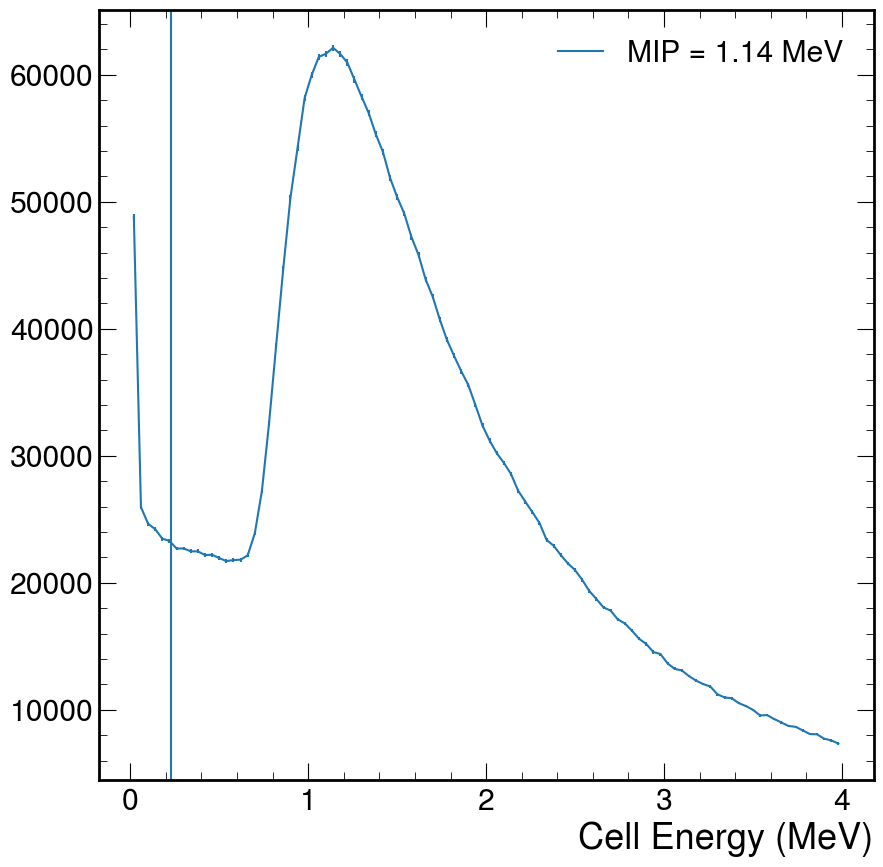

In [3]:
y,x=np.histogram(ak.flatten(arrays['muon']["MuographyHits.energy"]), bins=100, range=(0, 0.004))
bc=(x[1:]+x[:-1])/2
MIP=list(bc[y==max(y)])[0] 
plt.errorbar(np.array(bc)*1000,np.array(y),yerr=np.sqrt(y))
plt.axvline(0.2*MIP*1000,label=f'MIP = {MIP*1000:.2f} MeV')
plt.xlabel('Cell Energy (MeV)')
plt.legend()

In [4]:
data_energy = arrays['muon'][f'MuographyHits.energy']

sigma = 0.56

# flatten to numpy
flat = ak.to_numpy(data_energy.layout.content)
noise = np.random.normal(0, sigma, size=len(flat))*MIP

# add noise
flat_smear = np.clip(flat + noise, a_min=1e-16, a_max=None)

# rebuild jagged array
offsets = ak.to_numpy(data_energy.layout.offsets)  # convert Index64 → numpy
lengths = offsets[1:] - offsets[:-1]
data_energy_smear = ak.unflatten(flat_smear, lengths)

data_MIP_cut = data_energy_smear > 0.2*MIP
data_cell_cut = ak.num(data_energy_smear[data_MIP_cut], axis=1) >= 2 #[True if len(cells)>=2 else False for cells in data_energy_smear[data_MIP_cut]]

In [7]:
data_x = arrays['muon'][f'MuographyHits.position.x'][np.array(data_cell_cut)]
data_y = arrays['muon'][f'MuographyHits.position.y'][np.array(data_cell_cut)]
data_z = arrays['muon'][f'MuographyHits.position.z'][np.array(data_cell_cut)]    
#reco_data_angle = np.array([vector_angle_reconstruct(np.array(xi,dtype=float), np.array(yi,dtype=float), np.array(zi,dtype=float)) for xi, yi, zi in zip(data_x,data_y,data_z)])
status = arrays['muon']["MCParticles.generatorStatus"]
mc_px = arrays['muon']["MCParticles.momentum.x"][status==1][np.array(data_cell_cut)]
mc_py = arrays['muon']["MCParticles.momentum.y"][status==1][np.array(data_cell_cut)]
mc_pz = arrays['muon']["MCParticles.momentum.z"][status==1][np.array(data_cell_cut)]
#mc_theta = theta_reconstruct(mc_px,mc_py,mc_pz)
#mc_phi = phi_reconstruct(mc_px,mc_py,mc_pz)
data_time = arrays['muon']["MuographyHitsContributions.time"][np.array(data_cell_cut)]
mc_status = arrays['muon']["MCParticles.generatorStatus"][status==1][np.array(data_cell_cut)]
mc_pdg = arrays['muon']["MCParticles.PDG"][status==1][np.array(data_cell_cut)]
mc_mass = arrays['muon']["MCParticles.mass"][status==1][np.array(data_cell_cut)]

mc_x = arrays['muon']["MCParticles.momentum.x"][status==1][np.array(data_cell_cut)]
mc_y = arrays['muon']["MCParticles.momentum.y"][status==1][np.array(data_cell_cut)]
mc_z = arrays['muon']["MCParticles.momentum.z"][status==1][np.array(data_cell_cut)]

In [8]:
import uproot
num = 10000
for i in range(int(len(mc_pdg)/num)):
    print(f"Processing: {i}", end='\r')
    branches = {
        "MuographyHits.position.x": data_x[i*num:(i+1)*num],
        "MuographyHits.position.y": data_y[i*num:(i+1)*num],
        "MuographyHits.position.z": data_z[i*num:(i+1)*num],
        "MuographyHits.energy_nonsmear": data_energy[np.array(data_cell_cut)][i*num:(i+1)*num],
        "MuographyHits.energy": data_energy_smear[np.array(data_cell_cut)][i*num:(i+1)*num],
        "MuographyHits.time": data_time[i*num:(i+1)*num],
        "MCParticles.generatorStatus": mc_status[i*num:(i+1)*num],
        "MCParticles.PDG": mc_pdg[i*num:(i+1)*num],
        "MCParticles.mass": mc_mass[i*num:(i+1)*num],
        "MCParticles.momentum.x": mc_x[i*num:(i+1)*num],
        "MCParticles.momentum.y": mc_y[i*num:(i+1)*num],
        "MCParticles.momentum.z": mc_z[i*num:(i+1)*num]
    }
    
    
    with uproot.recreate(f'training/128_25depth/128_channels_25depth_{i}.root') as fout:
        fout["events"] = branches

In [ ]:
path_to_result = "data/training/128_model"
npz_unpacked = np.load(path_to_result+"/predictions_appended_test.npz", allow_pickle=True) 

predictions_unnormalized = npz_unpacked['outputs_scaled'].item()
targets_unnormalized = npz_unpacked['targets_scaled'].item()
predictions = npz_unpacked['outputs'].item()
targets = npz_unpacked['targets'].item()
meta = npz_unpacked['meta']
predictions_theta = np.degrees(predictions_unnormalized["theta"])


In [ ]:
import os
import pickle
import awkward as ak
import uproot as ur

files = sorted(os.listdir('training/128_channel_test/'))
merged = None  # will hold concatenated dataset
for type in ['free','target']:
    print(f'processing {type} ####################')
    with ur.recreate(f"training/128_model/{type}_merge.root") as fout:
        fout.mktree("events", {
            "Detector": "int32",
            "MuographyHits.energy": "var * float32",
            "MuographyHits.time": "var * float32",
            "MuographyHits.position.x": "var * float32",
            "MuographyHits.position.y": "var * float32",
            "MuographyHits.position.z": "var * float32",
            "MCParticles.momentum.x": "var * float32",
            "MCParticles.momentum.y": "var * float32",
            "MCParticles.momentum.z": "var * float32",
            "MCParticles.vertex.x": "var * float32",
            "MCParticles.vertex.y": "var * float32",
            "MCParticles.vertex.z": "var * float32",
            "MCParticles.mass": "var * float32",
            "MCParticles.PDG": "var * float32",
            "MCParticles.generatorStatus": "var * float32"
        })
        for i, file in enumerate(files[:5]):
            if type not in file: continue
            with ur.open(f'training/128_channel_test/{file}:events') as f:
                arrays = f.arrays()
                
            print(f'Processing: {file}', end='\r',flush=True)
        
            cut = [file in i for i in meta[:, 0]]
            arrays["GNN.theta"] = predictions_theta[cut]
        
            branches = {
                "Detector": ak.Array([file.split('_')[3]] * len(arrays)),
                "MuographyHits.position.x": arrays[f"MuographyHits.position.x"],
                "MuographyHits.position.y": arrays[f"MuographyHits.position.y"],
                "MuographyHits.position.z": arrays[f"MuographyHits.position.z"],
                "MuographyHits.energy": arrays[f"MuographyHits.energy"],
                "MuographyHits.time": arrays[f"MuographyHits.time"],
                "MCParticles.PDG": arrays["MCParticles.PDG"],
                "MCParticles.generatorStatus": arrays["MCParticles.generatorStatus"],
                "MCParticles.mass": arrays["MCParticles.mass"],
                "MCParticles.momentum.x": arrays["MCParticles.momentum.x"],
                "MCParticles.momentum.y": arrays["MCParticles.momentum.y"],
                "MCParticles.momentum.z": arrays["MCParticles.momentum.z"],
                "MuographyHits.theta": arrays["MuographyHits.theta"],
                "MuographyHits.phi": arrays["MuographyHits.phi"],
                "MCParticles.theta": ak.flatten(arrays["MCParticles.theta"]),
                "MCParticles.phi": ak.flatten(arrays["MCParticles.phi"]),
                "GNN.theta": ak.flatten(arrays["GNN.theta"]),
            }
        
            # Wrap dict into an Awkward record array
            batch = ak.Array(branches)
        
            # Concatenate across files
            merged = batch if merged is None else ak.concatenate([merged, batch], axis=0)
        
        # Save once at the end
        fout['events'].extend(merged)

print('Done')

In [ ]:
import os
import numpy as np
import awkward as ak
import uproot as ur

files = sorted(os.listdir('training/128_channel_test/'))

for type in ['free', 'target']:
    with ur.recreate(f"training/128_model/{type}_merge.root") as fout:
        fout.mktree("events", {})

        merged = None
        for i, file in enumerate(files[:5]):
            if type not in file:
                continue

            with ur.open(f'training/128_channel_test/{file}:events') as f:
                arrays = f.arrays()

            print(f'Processing: {file}', end='\r', flush=True)

            cut = [file in i for i in meta[:, 0]]
            arrays["GNN.theta"] = ak.Array(predictions_theta[cut])
            arrays["Detector"] = np.full(len(arrays), int(file.split('_')[3]), dtype=np.int32)

            # Pick out only the branches you want
            branches = {
                "Detector": arrays["Detector"],
                "MuographyHits.position.x": arrays["MuographyHits.position.x"],
                "MuographyHits.position.y": arrays["MuographyHits.position.y"],
                "MuographyHits.position.z": arrays["MuographyHits.position.z"],
                "MuographyHits.energy": arrays["MuographyHits.energy"],
                "MuographyHits.time": arrays["MuographyHits.time"],
                "MCParticles.PDG": arrays["MCParticles.PDG"],
                "MCParticles.generatorStatus": arrays["MCParticles.generatorStatus"],
                "MCParticles.mass": arrays["MCParticles.mass"],
                "MCParticles.momentum.x": arrays["MCParticles.momentum.x"],
                "MCParticles.momentum.y": arrays["MCParticles.momentum.y"],
                "MCParticles.momentum.z": arrays["MCParticles.momentum.z"],
                "MCParticles.theta": arrays["MCParticles.theta"],
                "MCParticles.phi": arrays["MCParticles.phi"],
                "GNN.theta": arrays["GNN.theta"],
            }

            # Merge dictionaries field by field
            if merged is None:
                merged = branches
            else:
                merged = {
                    key: ak.concatenate([merged[key], branches[key]], axis=0)
                    for key in merged
                }

        # ✅ Write as dict, not ak.Array
        fout['events'].extend(merged)


In [ ]:
path_to_result = "data/training/"
npz_unpacked = np.load(path_to_result+"/predictions_appended_test.npz", allow_pickle=True) 

predictions_unnormalized = npz_unpacked['outputs_scaled'].item()
targets_unnormalized = npz_unpacked['targets_scaled'].item()
predictions = npz_unpacked['outputs'].item()
targets = npz_unpacked['targets'].item()
meta = npz_unpacked['meta']
predictions_theta = np.degrees(predictions_unnormalized["theta"])

In [ ]:
import os
import pickle
import awkward as ak
import uproot as ur

files = os.listdir('training/test_data1/')
merged = None  # will hold concatenated dataset

for i, file in enumerate(files):
    with ur.open(f'training/test_data1/{file}:events') as f:
        arrays = f.arrays([
            "MuographyHits.energy", 
            "MuographyHits.theta", 
            "MuographyHits.phi", 
            "MCParticles.theta", 
            "MCParticles.phi"
        ])

    print(f'Processing: {file}')

    cut = [file in i for i in meta[:, 0]]
    arrays["GNN.theta"] = predictions_theta[cut]

    branches = {
        "MuographyHits.energy": ak.sum(arrays["MuographyHits.energy"], axis=-1),
        "MuographyHits.theta": arrays["MuographyHits.theta"],
        "MuographyHits.phi": arrays["MuographyHits.phi"],
        "MCParticles.theta": ak.flatten(arrays["MCParticles.theta"]),
        "MCParticles.phi": ak.flatten(arrays["MCParticles.phi"]),
        "GNN.theta": ak.flatten(arrays["GNN.theta"]),
    }

    # Wrap dict into an Awkward record array
    batch = ak.Array(branches)

    # Concatenate across files
    merged = batch if merged is None else ak.concatenate([merged, batch], axis=0)

# Save once at the end
with open("data/training/merge_single.pkl", "wb") as fout:
    pickle.dump(merged, fout)